In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
! pip install -q bitsandbytes diffusers==0.25.1 transformers accelerate datasets wandb gdown
! pip install -q xformers==0.0.17

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
!pip show diffusers

In [3]:
import os
import json
import accelerate
import wandb
import random
from datasets import Dataset, load_dataset, Features, Value
from PIL import Image
import numpy as np
import cv2
import datasets
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer, DataCollatorWithPadding#, AutoImageProcessor, UperNetForSemanticSegmentation

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionInpaintPipeline,
    UNet2DConditionModel,
)
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor

# from colors import ade_palette
# from utils import map_colors_rgb
# from colors import OBJECTS, SITTING, LIGHTING, TABLES, CLOSETS

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!gdown 1nL1U_UirQTKfjMO-Sk90kLhWBo1LYG2N  # image_captions.json
!gdown 1-12WtQ6HfJVNL4xCe3ZDMuwVCLxUj4N7  # interior_verse_subset.zip
# !gdown 1Imqc0XrkBChJ4z31MpwGF8eoz--Oge_9  # interiorverse120.zip
# !gdown 1-0SE_XOj8DmTQF4YbeMKwPSyuWIc198S  # interiorverse80.zip
!gdown 1MbLcq3dLoT-_-8X2MzS3_M7eVpco8yRh # val_images_interio120.zip
!unzip -q '/content/interior_verse_subset.zip' -d '/content'
!unzip -q '/content/val_images_interio120.zip' -d '/content'

In [11]:
!unzip -q '/content/interior_verse_subset.zip' -d '/content'
!unzip -q '/content/val_images_interio120.zip' -d '/content'

In [ ]:
def prepare_img_captions(caption_file_path, tokenizer, image_dir, token_limit):
    with open(caption_file_path, 'r') as f:
        caption_data = json.load(f)

    image_names_lst = []
    caption_dict = {}
    for image_name, caption in caption_data.items():
        if os.path.exists(f'{image_dir}{image_name}'):
            image_names_lst.append(image_name)
            tokenizer_op = tokenizer(caption, truncation=True)
            caption_tokens = tokenizer_op['input_ids']
            if len(caption_tokens) > token_limit:
                caption_tokens = caption_tokens[:token_limit-1]
                for i in range(len(caption_tokens)-1, -1, -1):
                    if caption_tokens[i] == 269:  # This indicates '.' is encountered
                        break
            caption_tokens = caption_tokens[1:i+1] # i+1 to ensure that '.' is included
            truncated_caption = tokenizer.decode(caption_tokens)
            caption_dict[image_name] = truncated_caption

    print(len(image_names_lst), len(caption_dict))

    return image_names_lst, caption_dict

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-inpainting", subfolder="tokenizer")
caption_file_path = '/content/image_captions.json'
image_dir = '/content/interior_verse_subset'
token_limit = 50
image_names_lst, caption_dict = prepare_img_captions(caption_file_path, tokenizer, image_dir, token_limit)

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

0 0


In [ ]:
train_transforms = transforms.Compose(
    [transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BILINEAR),
     transforms.ToTensor(),
    # transforms.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711]),
    ])

#### Logic to create dataset with mask using segmented items (damn slow)

In [ ]:
def filter_items(colors_list,items_list,items_to_mask):
    """
    Filters items and their corresponding colors from given lists, excluding
    specified items.

    Args:
        colors_list: A list or numpy array of colors corresponding to items.
        items_list: A list or numpy array of items.
        items_to_remove: A list or numpy array of items to be removed.

    Returns:
        A tuple of two lists or numpy arrays: filtered colors and filtered
        items.
    """
    filtered_colors = []
    filtered_items = []
    for color, item in zip(colors_list, items_list):
        if item in items_to_mask:
            filtered_colors.append(color)
            filtered_items.append(item)
    return filtered_colors, filtered_items

def get_segmentation_pipeline():
    """Method to load the segmentation pipeline
    Returns:
        Tuple[AutoImageProcessor, UperNetForSemanticSegmentation]: segmentation pipeline
    """
    image_processor = AutoImageProcessor.from_pretrained(
        "openmmlab/upernet-convnext-small"
    )
    image_segmentor = UperNetForSemanticSegmentation.from_pretrained(
        "openmmlab/upernet-convnext-small"
    )
    # image_segmentor = image_segmentor.to('cuda')
    return image_processor, image_segmentor

@torch.inference_mode()
@torch.autocast('cuda')
def segment_image(image, image_processor, image_segmentor):
    """
    Segments an image using a semantic segmentation model.

    Args:
        image (Image): The input image to be segmented.
        image_processor (AutoImageProcessor): The processor to prepare the
            image for segmentation.
        image_segmentor (UperNetForSemanticSegmentation): The semantic
            segmentation model used to identify different segments in the image.

    Returns:
        Image: The segmented image with each segment colored differently based
            on its identified class.
    """
    # image_processor, image_segmentor = get_segmentation_pipeline()
    pixel_values = image_processor(image, return_tensors="pt").pixel_values
    with torch.no_grad():
        outputs = image_segmentor(pixel_values)

    seg = image_processor.post_process_semantic_segmentation(
        outputs, target_sizes=[image.size[::-1]])[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color
    color_seg = color_seg.astype(np.uint8)
    seg_image = Image.fromarray(color_seg).convert('RGB')
    return seg_image

def combine_rgb_with_mask(rgb_image, mask_image):
    """
    Combines an RGB image with a black and white mask image.
    The RGB image remains unchanged in black areas of the mask and turns white in white areas.

    Args:
        rgb_image_path: Path to the RGB image file.
        mask_image_path: Path to the black and white mask image file.
    """
    # Load images
    rgb_image = np.array(rgb_image)
    mask_image = np.array(mask_image)

    # Ensure images have the same dimensions
    if rgb_image.shape[:2] != mask_image.shape:
      raise ValueError("RGB image and mask must have the same dimensions.")

    # Convert mask to 3 channels to match RGB image
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2BGR)

    # Blend the images
    blended_image = cv2.addWeighted(rgb_image, 1, mask_image, 1, 0)

    return blended_image

def generate_mask(input_image, seg_image_processor, seg_image_segmentor, object_items):
    real_seg = np.array(segment_image(input_image,
                                      seg_image_processor,
                                      seg_image_segmentor))
    unique_colors = np.unique(real_seg.reshape(-1, real_seg.shape[2]), axis=0)
    unique_colors = [tuple(color) for color in unique_colors]
    segment_items = [map_colors_rgb(i) for i in unique_colors]
    possible_mask_items = []
    for item in segment_items:
        if item in object_items:
            possible_mask_items.append(item)
    selected_item = [random.choice(possible_mask_items)]
    chosen_colors, segment_items = filter_items(
        colors_list=unique_colors,
        items_list=segment_items,
        items_to_mask=selected_item
    )
    mask = np.zeros_like(real_seg)
    for color in chosen_colors:
        color_matches = (real_seg == color).all(axis=2)
        mask[color_matches] = 1

    image_np = np.array(input_image)
    image = Image.fromarray(image_np).convert("RGB")
    mask_array = (mask * 255).astype(np.uint8)
    mask_image = Image.fromarray(mask_array).convert("L")
    input_mask_array = combine_rgb_with_mask(image, mask_image)
    input_mask_image = Image.fromarray(input_mask_array).convert('RGB')

    return mask_image, input_mask_image

In [ ]:
seg_image_processor, seg_image_segmentor = get_segmentation_pipeline()

object_items_dict = [OBJECTS, SITTING, LIGHTING, TABLES, CLOSETS]
object_items = []
for dict_item in object_items_dict:
    for colour, item in dict_item.items():
        object_items.append(item)

200 200


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
class InpaintingDataset(Dataset):
    def __init__(self, image_names, caption_dict, tokenizer, img_dir, transform=None):
        self.data = image_names
        self.caption_dict = caption_dict
        self.tokenizer = tokenizer
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        return {
            'image_names': self.data[idx],
            'idx': idx
        }

    def tokenize_function(self, caption):
        return self.tokenizer(caption, truncation=True)

    def collate_fn(self, batch):
        image_names = [item['image_names'] for item in batch]
        img_array = []
        mask_array = []
        img_mask_array = []
        for image in image_names:
            img = Image.open(f'{self.img_dir}{image}')
            mask, img_mask = generate_mask(img, seg_image_processor, seg_image_segmentor, object_items)
            if self.transform:
                transform_img = self.transform(img)
                transform_mask = self.transform(mask)
                transform_img_mask = self.transform(img_mask)
            img_array.append(transform_img)
            mask_array.append(transform_mask)
            img_mask_array.append(transform_img_mask)
        img_tensor = torch.stack(img_array)
        mask_tensor = torch.stack(mask_array)
        img_mask_tensor = torch.stack(img_mask_array)
        captions = [self.caption_dict[image_name] for image_name in image_names]
        tokenized_caption_samples = []
        for caption in captions:
            tokenized_caption_dict = self.tokenize_function(caption)
            tokenized_caption_samples.append(tokenized_caption_dict)
        collated_captions = self.data_collator(tokenized_caption_samples)
        caption_tokens = collated_captions['input_ids']

        return {
            'image_names': image_names,
            'pixel_values': img_tensor,
            'captions': captions,
            'input_ids': caption_tokens,
            "masks": mask_tensor,
            "masked_images": img_mask_tensor
        }

In [ ]:
dataset = InpaintingDataset(image_names_lst, caption_dict, tokenizer, image_dir, train_transforms)

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=True)
print(len(dataset))

200


In [ ]:
for idx, batch in enumerate(dataloader):
    if idx > 0:
        break
    image_names = batch['image_names']  # List of image names corresponding to each data slice
    images = batch['pixel_values']
    captions = batch['captions']  # List of captions corresponding to each data slice
    caption_tokens = batch['input_ids']  # Shape: [batch_size, max_seq_len]
    masks = batch['masks']
    img_masks = batch['masked_images']
    print(idx)
    print(images.shape, image_names)
    print(masks.shape, img_masks.shape)
    print(captions)
    print(caption_tokens.shape)
    print(tokenizer.batch_decode(caption_tokens))
    print('---------')

#### Logic to create dataset with white masks on random positions

In [ ]:
def apply_random_patch(img):
    """
    Applies a white patch of random shape and size on a random position of the image.

    Args:
        image: A NumPy array representing the RGB image (shape (512, 512, 3)).

    Returns:
        A tuple containing:
            - modified_image: The image with the applied white patch.
            - mask: The black and white mask of the applied patch.
    """

    # Target patch area as a percentage of image area
    target_patch_area_ratio = 0.10

    image = np.array(img)

    # Calculate target patch area in pixels
    image_area = image.shape[0] * image.shape[1]
    target_patch_area = int(image_area * target_patch_area_ratio)

    # Define minimum and maximum dimensions for the patch
    min_dim = int(np.sqrt(target_patch_area / 4))
    max_dim = int(np.sqrt(target_patch_area))

    # Generate random patch dimensions within the limits
    patch_height = np.random.randint(min_dim, max_dim + 1)
    patch_width = np.random.randint(min_dim, max_dim + 1)

    # Ensure patch fits within image boundaries
    max_y = image.shape[0] - patch_height
    max_x = image.shape[1] - patch_width

    # Generate random top-left corner coordinates
    top_left_y = np.random.randint(0, max_y + 1)
    top_left_x = np.random.randint(0, max_x + 1)

    # Create a mask with random points within the patch area
    mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
    mask[top_left_y:top_left_y + patch_height, top_left_x:top_left_x + patch_width] = 255

    # Create random points for a more organic shaped patch (optional)
    num_points = int(target_patch_area * 0.1)  # Adjust for desired point density
    for _ in range(num_points):
        random_y = np.random.randint(top_left_y, top_left_y + patch_height)
        random_x = np.random.randint(top_left_x, top_left_x + patch_width)
        cv2.circle(mask, (random_x, random_y), 2, 255, -1)

    # Apply white patch to the image using the mask
    modified_image = image.copy()
    modified_image[mask == 255] = [255, 255, 255]  # Set patch to white
    return mask, modified_image

def generate_mask(input_image):
    mask_array, input_mask_array = apply_random_patch(input_image)
    mask_image = Image.fromarray(mask_array).convert("L")
    input_mask_image = Image.fromarray(input_mask_array).convert('RGB')

    return mask_image, input_mask_image

In [ ]:
class InpaintingDataset(Dataset):
    def __init__(self, image_names, caption_dict, tokenizer, img_dir, transform=None):
        self.data = image_names
        self.caption_dict = caption_dict
        self.tokenizer = tokenizer
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        return {
            'image_names': self.data[idx],
            'idx': idx
        }

    def tokenize_function(self, caption):
        return self.tokenizer(caption, truncation=True)

    def collate_fn(self, batch):
        image_names = [item['image_names'] for item in batch]
        img_array = []
        mask_array = []
        img_mask_array = []
        i = 0
        for image in image_names:
            i += 1
            img = Image.open(f'{self.img_dir}{image}')
            mask, img_mask = generate_mask(img)
            if i == 7:
                mask.save('/content/mask.jpg')
                img_mask.save('/content/img_mask.jpg')
            if self.transform:
                transform_img = self.transform(img)
                transform_mask = self.transform(mask)
                transform_img_mask = self.transform(img_mask)
            img_array.append(transform_img)
            mask_array.append(transform_mask)
            img_mask_array.append(transform_img_mask)
        img_tensor = torch.stack(img_array)
        mask_tensor = torch.stack(mask_array)
        img_mask_tensor = torch.stack(img_mask_array)
        captions = [self.caption_dict[image_name] for image_name in image_names]
        tokenized_caption_samples = []
        for caption in captions:
            tokenized_caption_dict = self.tokenize_function(caption)
            tokenized_caption_samples.append(tokenized_caption_dict)
        collated_captions = self.data_collator(tokenized_caption_samples)
        caption_tokens = collated_captions['input_ids']

        return {
            'image_names': image_names,
            'pixel_values': img_tensor,
            'captions': captions,
            'input_ids': caption_tokens,
            "masks": mask_tensor,
            "masked_images": img_mask_tensor
        }

In [ ]:
dataset = InpaintingDataset(image_names_lst, caption_dict, tokenizer, image_dir, train_transforms)

batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=True)
print(len(dataset))

200


In [ ]:
for idx, batch in enumerate(dataloader):
    if idx > 0:
        break
    image_names = batch['image_names']  # List of image names corresponding to each data slice
    images = batch['pixel_values']
    captions = batch['captions']  # List of captions corresponding to each data slice
    caption_tokens = batch['input_ids']  # Shape: [batch_size, max_seq_len]
    masks = batch['masks']
    img_masks = batch['masked_images']
    print(idx)
    print(f'images.shape : {images.shape}, image_names[:2] :{image_names[:2]}')
    print(f'masks.shape: {masks.shape}, img_masks.shape : {img_masks.shape}')
    print(f'captions : {captions[0]}')
    print(f'caption_tokens.shape : {caption_tokens.shape}')
    print(f'new captions : {tokenizer.decode(caption_tokens[0])}')
    print('---------')

0
images.shape : torch.Size([64, 3, 512, 512]), image_names[:2] :['L3D187S8ENDIMEDNXQUI5L7ELUF3P3WM888_013_im.jpg', 'L3D187S21ENDIDR2JSAUI5NFSLUF3P3X2888_010_im.jpg']
masks.shape: torch.Size([64, 1, 512, 512]), img_masks.shape : torch.Size([64, 3, 512, 512])
captions : the room is a small, dimly lit bedroom with a bed occupying a significant portion of the space. the bed is positioned near a wall, and there is a doorway leading to another room.
caption_tokens.shape : torch.Size([64, 50])
new captions : <|startoftext|>the room is a small, dimly lit bedroom with a bed occupying a significant portion of the space. the bed is positioned near a wall, and there is a doorway leading to another room. <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
---------


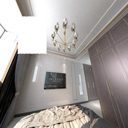

In [ ]:
Image.open('/content/img_mask.jpg').resize((128, 128))

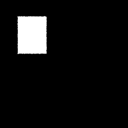

In [ ]:
Image.open('/content/mask.jpg').resize((128, 128))

#### Create validation file

#####
Example `validation.jsonl`
    
    {"file_name": "img1.png", "mask_file_name": "vertical-bar-mask.png", "text": "a satellite image"}

    {"file_name": "img1.png", "mask_file_name": "vertical-bar-mask.png", "text": "a satellite image of a beach"}
    ...

Usage:
    
    pipe = StableDiffusionInpaintPipeline(...)
    
    pipe.unet.load_attn_procs('.../pytorch_model.bin', use_safetensors=False)

In [ ]:
!gdown 1nL1U_UirQTKfjMO-Sk90kLhWBo1LYG2N  # image_captions.json
!gdown 1Imqc0XrkBChJ4z31MpwGF8eoz--Oge_9  # interiorverse120.zip
!unzip -q '/content/interiorverse120.zip' -d '/content'

In [ ]:
len(os.listdir('/content/im_exr_120_jpg'))

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-inpainting", subfolder="tokenizer")
caption_file_path = '/content/image_captions.json'
image_dir = '/content/im_exr_120_jpg'
token_limit = 50
image_names_lst, caption_dict = prepare_img_captions(caption_file_path, tokenizer, image_dir, token_limit)

In [ ]:
def apply_random_patch(img):
    """
    Applies a white patch of random shape and size on a random position of the image.

    Args:
        image: A NumPy array representing the RGB image (shape (512, 512, 3)).

    Returns:
        A tuple containing:
            - modified_image: The image with the applied white patch.
            - mask: The black and white mask of the applied patch.
    """

    # Target patch area as a percentage of image area
    target_patch_area_ratio = 0.10

    image = np.array(img)

    # Calculate target patch area in pixels
    image_area = image.shape[0] * image.shape[1]
    target_patch_area = int(image_area * target_patch_area_ratio)

    # Define minimum and maximum dimensions for the patch
    min_dim = int(np.sqrt(target_patch_area / 4))
    max_dim = int(np.sqrt(target_patch_area))

    # Generate random patch dimensions within the limits
    patch_height = np.random.randint(min_dim, max_dim + 1)
    patch_width = np.random.randint(min_dim, max_dim + 1)

    # Ensure patch fits within image boundaries
    max_y = image.shape[0] - patch_height
    max_x = image.shape[1] - patch_width

    # Generate random top-left corner coordinates
    top_left_y = np.random.randint(0, max_y + 1)
    top_left_x = np.random.randint(0, max_x + 1)

    # Create a mask with random points within the patch area
    mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
    mask[top_left_y:top_left_y + patch_height, top_left_x:top_left_x + patch_width] = 255

    # Create random points for a more organic shaped patch (optional)
    num_points = int(target_patch_area * 0.1)  # Adjust for desired point density
    for _ in range(num_points):
        random_y = np.random.randint(top_left_y, top_left_y + patch_height)
        random_x = np.random.randint(top_left_x, top_left_x + patch_width)
        cv2.circle(mask, (random_x, random_y), 2, 255, -1)

    # Apply white patch to the image using the mask
    modified_image = image.copy()
    modified_image[mask == 255] = [255, 255, 255]  # Set patch to white
    return mask, modified_image

def generate_mask(input_image):
    mask_array, input_mask_array = apply_random_patch(input_image)
    mask_image = Image.fromarray(mask_array).convert("L")
    input_mask_image = Image.fromarray(input_mask_array).convert('RGB')

    return mask_image, input_mask_image

In [ ]:
image_validations = image_names_lst[-10:]
print(len(image_validations))

10


In [ ]:
os.mkdir('/content/val_images/')

In [ ]:
val_image_name_lst = []
mask_image_name_lst = []
input_mask_image_name_lst = []
caption_lst = []
for image_name in image_validations:
    image_first_name = image_name.split('.')[0]
    image_ext = image_name.split('.')[-1]

    input_image = Image.open(f'/content/im_exr_120_jpg/{image_name}')
    input_image.save(f'/content/val_images/{image_name}')
    val_image_name_lst.append(image_name)

    mask_image, input_mask_image = generate_mask(input_image)

    mask_image_name = f'{image_first_name}_mask.{image_ext}'
    mask_image.save(f'/content/val_images/{mask_image_name}')
    mask_image_name_lst.append(mask_image_name)

    input_mask_image_name = f'{image_first_name}_ip_mask.{image_ext}'
    input_mask_image.save(f'/content/val_images/{input_mask_image_name}')
    input_mask_image_name_lst.append(input_mask_image_name)

    caption = caption_dict[image_name]
    caption_lst.append(caption)

print(len(val_image_name_lst), len(mask_image_name_lst), len(input_mask_image_name_lst), len(caption_lst))

10 10 10 10


In [ ]:
iname = val_image_name_lst[5]
mname = mask_image_name_lst[5]
imname = input_mask_image_name_lst[5]
cap = caption_lst[5]

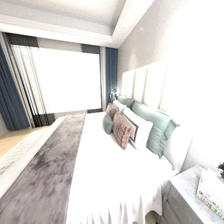

In [ ]:
Image.open(f'/content/val_images/{iname}').resize((224, 224))

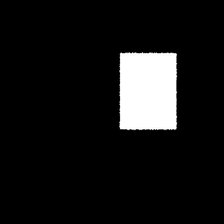

In [ ]:
Image.open(f'/content/val_images/{mname}').resize((224, 224))

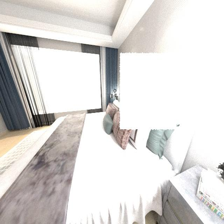

In [ ]:
Image.open(f'/content/val_images/{imname}').resize((224, 224))

In [ ]:
cap

'the room is a large, well - lit bedroom with a large bed occupying a significant portion of the space. the bed is adorned with a variety of pillows, including blue and white ones.'

In [ ]:
validation_json_dict = []
for i in range(len(val_image_name_lst)):
    item_dict = {}
    item_dict["file_name"] =  val_image_name_lst[i]
    item_dict["mask_file_name"] = mask_image_name_lst[i]
    item_dict["text"] = caption_lst[i]
    validation_json_dict.append(item_dict)
len(validation_json_dict)

10

In [ ]:
import json

# Open the file for writing in text mode (use 'w')
with open("/content/validation.jsonl", "w") as file:
    # Dump each dictionary as a JSON object followed by a newline character
    for item in validation_json_dict:
        json.dump(item, file)
        file.write("\n")

print("List of dictionaries successfully written to data.jsonl")


List of dictionaries successfully written to data.jsonl


In [ ]:
# Open the file for reading in text mode (use 'r')
with open("/content/validation.jsonl", "r") as file:
    # Initialize an empty list to store the data
    data = []

    # Read line by line
    for line in file:
        # Strip leading/trailing whitespace and check if the line is not empty
        if line.strip():
            # Load the JSON object from the line
            item = json.loads(line)
            # Append the parsed data to the list
            data.append(item)

print("Data successfully read from data.jsonl:")
print(len(data))

for idx, item in enumerate(data):
    print(idx , ':', item)

Data successfully read from data.jsonl:
10
0 : {'file_name': 'L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im.jpg', 'mask_file_name': 'L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_mask.jpg', 'text': 'the room is a large, well - lit living room with a modern design. it features a variety of furniture, including a couch, a chair, and a dining table.'}
1 : {'file_name': 'L3D124S8ENDIMPU2KQUI5NYALUF3P3WK888_004_im.jpg', 'mask_file_name': 'L3D124S8ENDIMPU2KQUI5NYALUF3P3WK888_004_im_mask.jpg', 'text': 'the room is a bedroom with a large closet or wardrobe. the closet is made of wood and has a mirrored surface. the room also features a window, which allows natural light to enter the space.'}
2 : {'file_name': 'L3D187S21ENDIDSP6XQUI5NGMLUF3P3UK888_010_im.jpg', 'mask_file_name': 'L3D187S21ENDIDSP6XQUI5NGMLUF3P3UK888_010_im_mask.jpg', 'text': 'the room is a large, open, and clean living room with a white color scheme. it features a couch, a chair, and a dining table.'}
3 : {'file_name': 'L3D187S8ENDI

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r '/content/val_images' '/content/gdrive/MyDrive/Interior_design_challenge_2024'

#### Logic to fine-tune inpainting

In [ ]:
!rm -rf '/content/interior_design_challenge_022024/'

In [ ]:
!git clone https://github.com/anilbhatt1/interior_design_challenge_022024.git

Cloning into 'interior_design_challenge_022024'...
remote: Enumerating objects: 617, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 617 (delta 64), reused 116 (delta 53), pack-reused 490
Receiving objects: 100% (617/617), 35.37 MiB | 30.01 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [ ]:
os.chdir('/content/interior_design_challenge_022024/terrain-diffusion/scripts')
print(os.getcwd())
!ls

/content/interior_design_challenge_022024/terrain-diffusion/scripts
build_text2rgb_captions.py  download_depth_dataset.py  train_text_to_image_lora_sd2_inpaint.py
build_text2rgb_dataset.py   download_rgb_dataset.py
captions_text2rgb.txt	    fix_text2rgb_dataset.py


In [ ]:
!accelerate launch train_text_to_image_lora_sd2_inpaint.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-inpainting" \
  --dataset_name="custom" \
  --caption_column="text" \
  --mask_mode="512train-very-large" \
  --mixed_precision="fp16" \
  --train_batch_size=8 \
  --gradient_accumulation_steps=4 \
  --num_train_epochs=1 \
  --checkpointing_steps=600 \
  --learning_rate=1e-06 \
  --lr_scheduler="constant" \
  --seed=0 \
  --validation_epochs=1 \
  --validation_file="/content/val_images_interio120/validation.jsonl"\
  --output_dir="output" \
  --enable_xformers_memory_efficient_attention \
  --report_to="wandb" \
  --caption_file_path='/content/image_captions.json' \
  --val_image_dir='/content/val_images_interio120/'

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-03-06 06:11:17.191247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attem

#### Inferencing using LORA weights

In [ ]:
unet = UNet2DConditionModel.from_pretrained(
    "runwayml/stable-diffusion-inpainting", subfolder="unet")
print(f'unet done')
unet.requires_grad_(False)
weight_dtype = torch.float16
unet.to('cuda', dtype=weight_dtype)

In [ ]:
lora_attn_procs = {}
for name in unet.attn_processors.keys():
    # print(f'name in unet : {name}')
    cross_attention_dim = (
        None
        if name.endswith("attn1.processor")
        else unet.config.cross_attention_dim
    )
    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]

    lora_attn_procs[name] = LoRAAttnProcessor(
        hidden_size=hidden_size,
        cross_attention_dim=cross_attention_dim,
        rank=4,
    )

In [ ]:
unet.set_attn_processor(lora_attn_procs)

In [ ]:
lora_layers = AttnProcsLayers(unet.attn_processors)

In [ ]:
pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=weight_dtype,
)
pipeline = pipeline.to('cuda')

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
unet_weight_path = '/content/interior_design_challenge_022024/terrain-diffusion/scripts/output/pytorch_lora_weights.safetensors'
pipeline.unet.load_attn_procs(unet_weight_path, use_safetensors=True)

In [ ]:
val_dir = '/content/val_images_interio120'
print(f'val_dir : {val_dir}')
val_examples = []
with open('/content/val_images_interio120/validation.jsonl', "r") as val_index_fp:
    for line in val_index_fp:
        val_examples.append(json.loads(line))
print(f'val_examples : {val_examples}')

val_dir : /content/val_images_interio120
val_examples : [{'file_name': 'L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_ip_mask.jpg', 'mask_file_name': 'L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_mask.jpg', 'text': 'the room is a large, well - lit living room with a modern design. it features a variety of furniture, including a couch, a chair, and a dining table.'}, {'file_name': 'L3D124S8ENDIMPU2KQUI5NYALUF3P3WK888_004_im_ip_mask.jpg', 'mask_file_name': 'L3D124S8ENDIMPU2KQUI5NYALUF3P3WK888_004_im_mask.jpg', 'text': 'the room is a bedroom with a large closet or wardrobe. the closet is made of wood and has a mirrored surface. the room also features a window, which allows natural light to enter the space.'}, {'file_name': 'L3D187S21ENDIDSP6XQUI5NGMLUF3P3UK888_010_im_ip_mask.jpg', 'mask_file_name': 'L3D187S21ENDIDSP6XQUI5NGMLUF3P3UK888_010_im_mask.jpg', 'text': 'the room is a large, open, and clean living room with a white color scheme. it features a couch, a chair, and a dining table.'}, {'

In [ ]:
# run inference
generator = torch.Generator(device='cuda')
generator = generator.manual_seed(0)
images = []
for val_example in val_examples:
    val_image_path = os.path.join(val_dir, val_example["file_name"])
    print(f'val_image_path : {val_image_path}')
    val_image = Image.open(val_image_path).resize((512, 512))
    mask_image = (
        Image.open(os.path.join(val_dir, val_example["mask_file_name"]))
        .convert("L")
        .resize((512, 512))
    )
    images.append(
        pipeline(
            prompt=val_example["text"],
            image=val_image,
            mask_image=mask_image,
            num_inference_steps=30,
            strength=1.0,
            generator=generator,
        ).images[0]
    )

val_image_path : /content/val_images_interio120/L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D124S8ENDIMPU2KQUI5NYALUF3P3WK888_004_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D187S21ENDIDSP6XQUI5NGMLUF3P3UK888_010_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D187S8ENDIMKV3ZYUI5NGMLUF3P3XA888_014_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D187S21ENDIMFYDYQUI5L7ELUF3P3WW888_018_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D124S8ENDIMKT5UIUI5NYALUF3P3WS888_003_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D124S8ENDIMO4UIYUI5NYALUF3P3XO888_003_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D124S8ENDIMLVMJQUI5L7ELUF3P3WQ888_002_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D187S21ENDIDRF4BIUI5L7GLUF3P3XI888_003_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

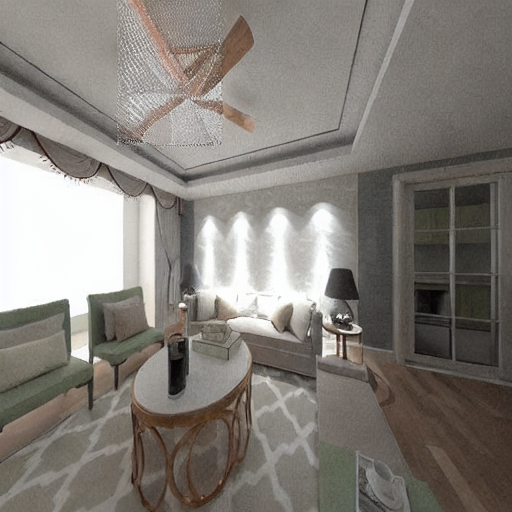

In [ ]:
img1 = images[0]
img1

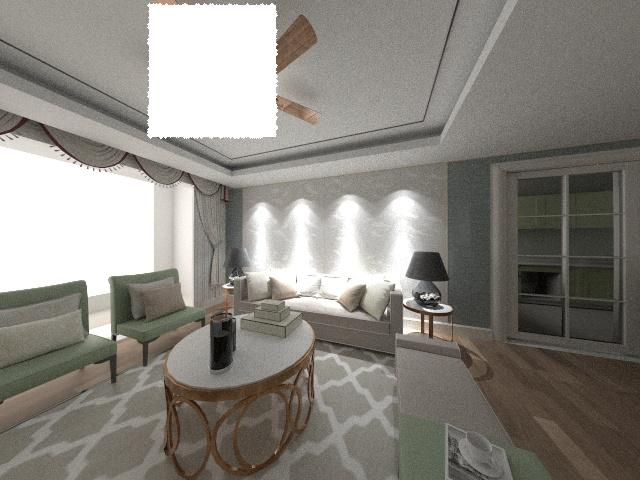

In [ ]:
Image.open('/content/val_images_interio120/L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_ip_mask.jpg')

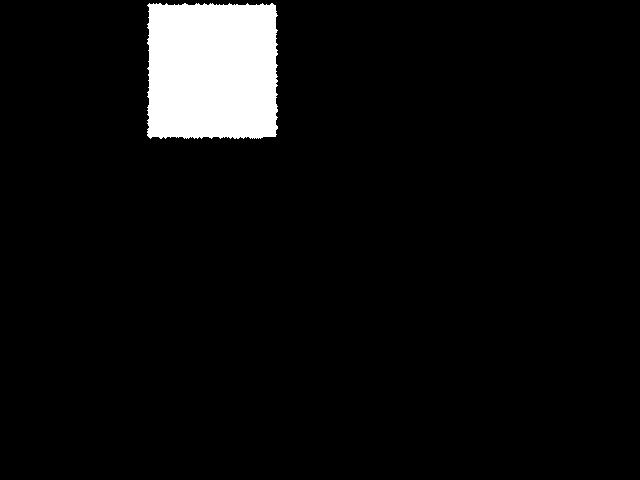

In [ ]:
Image.open('/content/val_images_interio120/L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_mask.jpg')

#### Logic to create dataset with full caption lengths

In [16]:
def prepare_img_captions(caption_file_path, image_dir):
    with open(caption_file_path, 'r') as f:
        caption_data = json.load(f)

    image_names_lst = []
    caption_dict = {}
    for image_name, caption in caption_data.items():
        if os.path.exists(f'{image_dir}{image_name}'):
            image_names_lst.append(image_name)
            caption_dict[image_name] = caption
    print(f' caption lengths : {len(image_names_lst)}, {len(caption_dict)}')

    return image_names_lst, caption_dict

In [20]:
tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-inpainting", subfolder="tokenizer")
caption_file_path = '/content/image_captions.json'
image_dir = '/content/exr_subset/120/'
image_names_lst, caption_dict = prepare_img_captions(caption_file_path, image_dir)

 caption lengths : 200, 200


In [26]:
train_transforms2 = transforms.Compose(
    [transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BILINEAR),
     transforms.ToTensor(),
    ])

In [22]:
def apply_random_patch(img):
    """
    Applies a white patch of random shape and size on a random position of the image.

    Args:
        image: A NumPy array representing the RGB image (shape (512, 512, 3)).

    Returns:
        A tuple containing:
            - modified_image: The image with the applied white patch.
            - mask: The black and white mask of the applied patch.
    """

    # Target patch area as a percentage of image area
    target_patch_area_ratio = 0.10

    image = np.array(img)

    # Calculate target patch area in pixels
    image_area = image.shape[0] * image.shape[1]
    target_patch_area = int(image_area * target_patch_area_ratio)

    # Define minimum and maximum dimensions for the patch
    min_dim = int(np.sqrt(target_patch_area / 4))
    max_dim = int(np.sqrt(target_patch_area))

    # Generate random patch dimensions within the limits
    patch_height = np.random.randint(min_dim, max_dim + 1)
    patch_width = np.random.randint(min_dim, max_dim + 1)

    # Ensure patch fits within image boundaries
    max_y = image.shape[0] - patch_height
    max_x = image.shape[1] - patch_width

    # Generate random top-left corner coordinates
    top_left_y = np.random.randint(0, max_y + 1)
    top_left_x = np.random.randint(0, max_x + 1)

    # Create a mask with random points within the patch area
    mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
    mask[top_left_y:top_left_y + patch_height, top_left_x:top_left_x + patch_width] = 255

    # Create random points for a more organic shaped patch (optional)
    num_points = int(target_patch_area * 0.1)  # Adjust for desired point density
    for _ in range(num_points):
        random_y = np.random.randint(top_left_y, top_left_y + patch_height)
        random_x = np.random.randint(top_left_x, top_left_x + patch_width)
        cv2.circle(mask, (random_x, random_y), 2, 255, -1)

    # Apply white patch to the image using the mask
    modified_image = image.copy()
    modified_image[mask == 255] = [255, 255, 255]  # Set patch to white
    return mask, modified_image

In [23]:
def generate_mask_inpaint(input_image):
    mask_array, input_mask_array = apply_random_patch(input_image)
    mask_image = Image.fromarray(mask_array).convert("L")
    input_mask_image = Image.fromarray(input_mask_array).convert('RGB')

    return mask_image, input_mask_image

In [54]:
class InpaintingDataset(Dataset):
    def __init__(self, image_names, caption_dict, tokenizer, img_dir, transform=None):
        self.data = image_names
        self.caption_dict = caption_dict
        self.tokenizer = tokenizer
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        return {
            'image_names': self.data[idx],
            'idx': idx
        }

    def tokenize_function(self, caption):
        return self.tokenizer(caption, truncation=False)

    def collate_fn(self, batch):
        image_names = [item['image_names'] for item in batch]
        img_array = []
        mask_array = []
        img_mask_array = []
        for image in image_names:
            img = Image.open(f'{self.img_dir}{image}')
            mask, img_mask = generate_mask_inpaint(img)
            if self.transform:
                transform_img = self.transform(img)
                transform_mask = self.transform(mask)
                transform_img_mask = self.transform(img_mask)
            img_array.append(transform_img)
            mask_array.append(transform_mask)
            img_mask_array.append(transform_img_mask)
        img_tensor = torch.stack(img_array)
        mask_tensor = torch.stack(mask_array)
        img_mask_tensor = torch.stack(img_mask_array)
        captions = [self.caption_dict[image_name] for image_name in image_names]
        tokenized_caption_samples = []
        for caption in captions:
            tokenized_caption_dict = self.tokenize_function(caption)
            print(f'tokenized_caption_dict : {len(tokenized_caption_dict["input_ids"])}')
            tokenized_caption_samples.append(tokenized_caption_dict)
        collated_captions = self.data_collator(tokenized_caption_samples)
        caption_tokens = collated_captions['input_ids']
        print(f'caption_tokens: {caption_tokens.size()}')

        return {
            'image_names': image_names,
            'pixel_values': img_tensor,
            'captions': captions,
            'input_ids': caption_tokens,
            "masks": mask_tensor,
            "masked_images": img_mask_tensor,
            'attention_mask': collated_captions['attention_mask']
        }

In [55]:
train_dataset = InpaintingDataset(image_names_lst, caption_dict, tokenizer, image_dir, train_transforms2)

In [56]:
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=train_dataset.collate_fn, shuffle=True)

In [57]:
for idx, batch in enumerate(train_dataloader):
    if idx > 0:
        break
    image_names = batch['image_names']  # List of image names corresponding to each data slice
    images = batch['pixel_values']
    captions = batch['captions']  # List of captions corresponding to each data slice
    caption_tokens = batch['input_ids']  # Shape: [batch_size, max_seq_len]
    masks = batch['masks']
    img_masks = batch['masked_images']
    print(idx)
    print(f'images.shape : {images.shape}, image_names[:2] :{image_names[:2]}')
    print(f'masks.shape: {masks.shape}, img_masks.shape : {img_masks.shape}')
    print(f'captions : {captions[0]}')
    print(f'caption_tokens.shape : {caption_tokens.shape}')
    print(f'new captions : {tokenizer.decode(caption_tokens[0])}')
    print('---------')

tokenized_caption_dict : 97
tokenized_caption_dict : 95
tokenized_caption_dict : 101
tokenized_caption_dict : 72
tokenized_caption_dict : 73
tokenized_caption_dict : 84
tokenized_caption_dict : 121
tokenized_caption_dict : 129
caption_tokens: torch.Size([8, 129])
0
images.shape : torch.Size([8, 3, 512, 512]), image_names[:2] :['L3D187S21ENDIDROQ6IUI5L7ELUF3P3X4888_006_im.jpg', 'L3D187S21ENDIML4O6YUI5L7ELUF3P3XG888_007_im.jpg']
masks.shape: torch.Size([8, 1, 512, 512]), img_masks.shape : torch.Size([8, 3, 512, 512])
captions : The room is a large, well-lit kitchen with wooden floors and wooden cabinets. The kitchen is equipped with various appliances, including a refrigerator, a microwave, an oven, and a sink. There are also multiple cups and bowls placed on the countertops. The room is furnished with a dining table and several chairs, providing a comfortable space for meals and gatherings. The overall atmosphere of the room is inviting and functional, making it an ideal space for cooki

In [43]:
text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-inpainting",subfolder="text_encoder")

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
text_encoder.requires_grad_(False)

In [58]:
def do_encode(inputs, text_encoder, device, max_seq_len=75):
    embeddings = []
    tokens = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    num_chunks = (tokens.size(1) + max_seq_len - 1) // max_seq_len
    print(f'tokens.size() : {tokens.size()}, attention_mask.size() : {attention_mask.size()}, num_chunks : {num_chunks}')

    text_encoder = text_encoder.to(device)
    tokens = tokens.to(device)
    attention_mask = attention_mask.to(device)

    for i in range(num_chunks):
        start_idx = i * max_seq_len
        end_idx = start_idx + max_seq_len
        print(f'i: {i}, start_idx : {start_idx}, end_idx : {end_idx}')
        chunk_tokens = tokens[:, start_idx:end_idx]
        # chunk_attention_mask = attention_mask[:, start_idx:end_idx]

        chunk_embeddings = text_encoder.text_model.embeddings.token_embedding(chunk_tokens)
        print(f'chunk_embeddings : {chunk_embeddings.size()} chunk_tokens.size : {chunk_tokens.size()}')

        chunk_size = chunk_tokens.size(1)
        position_ids = torch.arange(start_idx, start_idx + chunk_size, dtype=torch.long)
        print(f'position_ids : {position_ids.size()} & {position_ids}')
        position_ids = position_ids.unsqueeze(0).expand(chunk_tokens.size(0), chunk_size)
        print(f'position_ids after expand: {position_ids.size()}')

        position_ids = torch.clamp(position_ids.to(device), max=text_encoder.text_model.embeddings.position_embedding.num_embeddings - 1)
        print(f'position_ids after clamp: {position_ids.size()}')
        position_embeddings = text_encoder.text_model.embeddings.position_embedding(position_ids)
        print(f'position_embeddings.size() : {position_embeddings.size()}')
        chunk_embeddings += position_embeddings
        print(f'chunk_embeddings after position_embeddings : {chunk_embeddings.size()}')

        embeddings.append(chunk_embeddings)

    concatenated_embeddings = torch.cat(embeddings, dim=1)
    print(f'concatenated_embeddings : {concatenated_embeddings.size()}')
    attention_mask_expanded = attention_mask.unsqueeze(1).unsqueeze(2).repeat(1, 1, attention_mask.shape[1], 1)
    print(f'attention_mask_expanded : {attention_mask_expanded.size()}')
    encoder_outputs = text_encoder.text_model.encoder(concatenated_embeddings, attention_mask=attention_mask_expanded)
    print(f'encoder_outputs : {encoder_outputs.last_hidden_state.size()}')
    return(encoder_outputs.last_hidden_state)


In [59]:
encoder_hidden_states = do_encode(batch, text_encoder, 'cpu')

tokens.size() : torch.Size([8, 123]), attention_mask.size() : torch.Size([8, 123]), num_chunks : 2
i: 0, start_idx : 0, end_idx : 75
chunk_embeddings : torch.Size([8, 75, 768]) chunk_tokens.size : torch.Size([8, 75])
position_ids : torch.Size([75]) & tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74])
position_ids after expand: torch.Size([8, 75])
position_ids after clamp: torch.Size([8, 75])
position_embeddings.size() : torch.Size([8, 75, 768])
chunk_embeddings after position_embeddings : torch.Size([8, 75, 768])
i: 1, start_idx : 75, end_idx : 150
chunk_embeddings : torch.Size([8, 48, 768]) chunk_tokens.size : torch.Size([8, 48])
position_ids : torch.Size([48]) & tensor([ 75,  76,  77,  78,  79,  80,

#### Experiments

##### Check if val_image_save dir exists or not

In [61]:
import os

directory = "/content/val_image_save/"

# Check if the directory exists
if not os.path.exists(directory):
    # Create the directory
    try:
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully!")
    except OSError as e:
        print(f"Error creating directory '{directory}': {e}")
else:
    print(f"Directory '{directory}' already exists.")

Directory '/content/val_image_save/' already exists.


##### Inferencing using LORA weights

In [ ]:
unet = UNet2DConditionModel.from_pretrained(
    "runwayml/stable-diffusion-inpainting", subfolder="unet")
print(f'unet done')
unet.requires_grad_(False)
weight_dtype = torch.float16
unet.to('cuda', dtype=weight_dtype)

In [ ]:
lora_attn_procs = {}
for name in unet.attn_processors.keys():
    # print(f'name in unet : {name}')
    cross_attention_dim = (
        None
        if name.endswith("attn1.processor")
        else unet.config.cross_attention_dim
    )
    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]

    lora_attn_procs[name] = LoRAAttnProcessor(
        hidden_size=hidden_size,
        cross_attention_dim=cross_attention_dim,
        rank=4,
    )

In [ ]:
unet.set_attn_processor(lora_attn_procs)

In [ ]:
lora_layers = AttnProcsLayers(unet.attn_processors)

In [ ]:
pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=weight_dtype,
)
pipeline = pipeline.to('cuda')

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
unet_weight_path = '/content/interior_design_challenge_022024/terrain-diffusion/scripts/output/pytorch_lora_weights.safetensors'
pipeline.unet.load_attn_procs(unet_weight_path, use_safetensors=True)

In [ ]:
val_dir = '/content/val_images_interio120'
print(f'val_dir : {val_dir}')
val_examples = []
with open('/content/val_images_interio120/validation.jsonl', "r") as val_index_fp:
    for line in val_index_fp:
        val_examples.append(json.loads(line))
print(f'val_examples : {val_examples}')

val_dir : /content/val_images_interio120
val_examples : [{'file_name': 'L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_ip_mask.jpg', 'mask_file_name': 'L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_mask.jpg', 'text': 'the room is a large, well - lit living room with a modern design. it features a variety of furniture, including a couch, a chair, and a dining table.'}, {'file_name': 'L3D124S8ENDIMPU2KQUI5NYALUF3P3WK888_004_im_ip_mask.jpg', 'mask_file_name': 'L3D124S8ENDIMPU2KQUI5NYALUF3P3WK888_004_im_mask.jpg', 'text': 'the room is a bedroom with a large closet or wardrobe. the closet is made of wood and has a mirrored surface. the room also features a window, which allows natural light to enter the space.'}, {'file_name': 'L3D187S21ENDIDSP6XQUI5NGMLUF3P3UK888_010_im_ip_mask.jpg', 'mask_file_name': 'L3D187S21ENDIDSP6XQUI5NGMLUF3P3UK888_010_im_mask.jpg', 'text': 'the room is a large, open, and clean living room with a white color scheme. it features a couch, a chair, and a dining table.'}, {'

In [ ]:
# run inference
generator = torch.Generator(device='cuda')
generator = generator.manual_seed(0)
images = []
for val_example in val_examples:
    val_image_path = os.path.join(val_dir, val_example["file_name"])
    print(f'val_image_path : {val_image_path}')
    val_image = Image.open(val_image_path).resize((512, 512))
    mask_image = (
        Image.open(os.path.join(val_dir, val_example["mask_file_name"]))
        .convert("L")
        .resize((512, 512))
    )
    images.append(
        pipeline(
            prompt=val_example["text"],
            image=val_image,
            mask_image=mask_image,
            num_inference_steps=30,
            strength=1.0,
            generator=generator,
        ).images[0]
    )

val_image_path : /content/val_images_interio120/L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D124S8ENDIMPU2KQUI5NYALUF3P3WK888_004_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D187S21ENDIDSP6XQUI5NGMLUF3P3UK888_010_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D187S8ENDIMKV3ZYUI5NGMLUF3P3XA888_014_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D187S21ENDIMFYDYQUI5L7ELUF3P3WW888_018_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D124S8ENDIMKT5UIUI5NYALUF3P3WS888_003_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D124S8ENDIMO4UIYUI5NYALUF3P3XO888_003_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D124S8ENDIMLVMJQUI5L7ELUF3P3WQ888_002_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

val_image_path : /content/val_images_interio120/L3D187S21ENDIDRF4BIUI5L7GLUF3P3XI888_003_im_ip_mask.jpg


  0%|          | 0/30 [00:00<?, ?it/s]

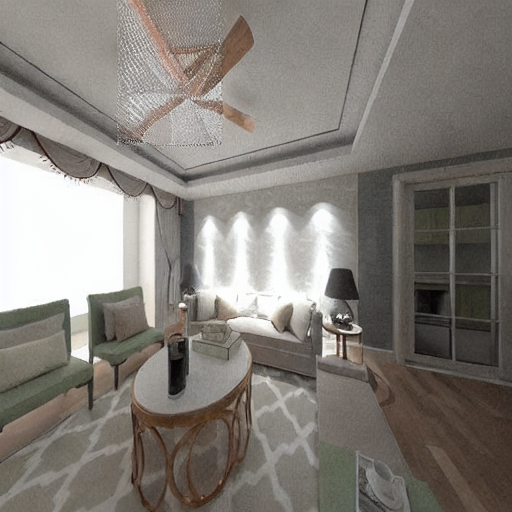

In [ ]:
img1 = images[0]
img1

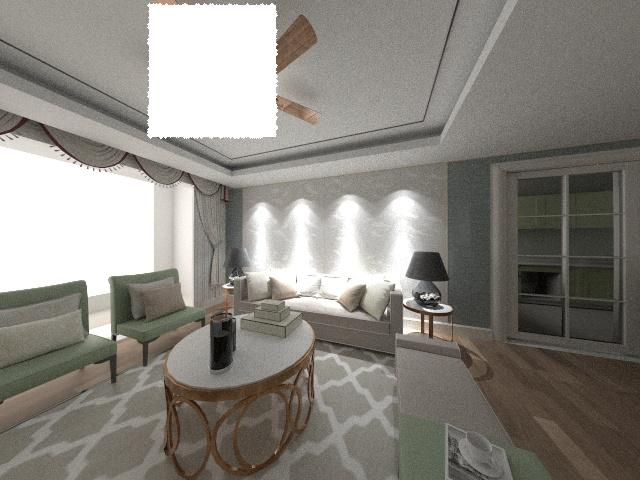

In [ ]:
Image.open('/content/val_images_interio120/L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_ip_mask.jpg')

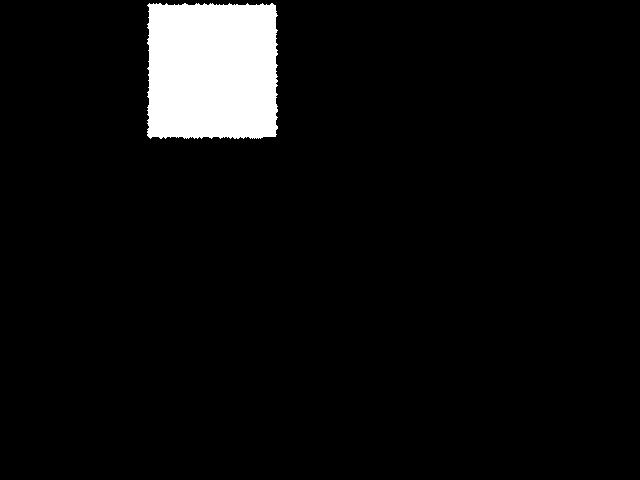

In [ ]:
Image.open('/content/val_images_interio120/L3D187S21ENDIMFH5CIUI5NYALUF3P3W2888_000_im_mask.jpg')

##### Checking random masking

In [ ]:
import cv2
import numpy as np

# Load the image
image = cv2.imread('/content/ikea1.jpg')

# Calculate the area of the patch
total_area = image.shape[0] * image.shape[1]
patch_area = 0.25 * total_area

# Create a black mask and initialize it with zeros
mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Generate random position and shape for the white patch
x = np.random.randint(0, image.shape[1])
y = np.random.randint(0, image.shape[0])
patch_width = np.random.randint(10, 50)
patch_height = np.random.randint(10, 50)

# Apply the white patch on the image and the mask
cv2.rectangle(image, (x, y), (x + patch_width, y + patch_height), (255, 255, 255), -1)
cv2.rectangle(mask, (x, y), (x + patch_width, y + patch_height), 255, -1)

# Save the masked image
cv2.imwrite('/content/masked_image.jpg', image)

# Save the black and white mask
cv2.imwrite('/content/mask.jpg', mask)

cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np



# Load your image (replace with your image path)
image = cv2.imread("/content/ikea1.jpg")

# Apply the random patch and get the mask
modified_image, mask = apply_random_patch(image)

# # Optional: Display the results
# cv2.imshow("Original Image", image)
# cv2.imshow("Modified Image", modified_image)
# cv2.imshow("Mask", mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the results (optional)
cv2.imwrite("/content/modified_image.jpg", modified_image)
cv2.imwrite("/content/mask.png", mask)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>


True

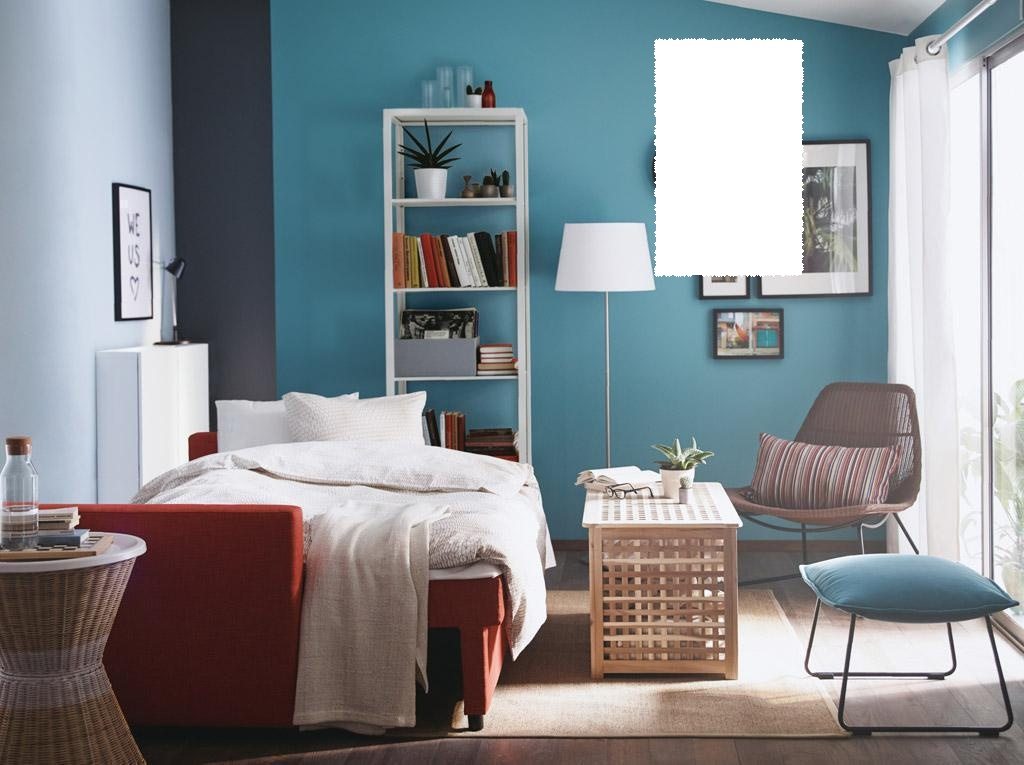

In [ ]:
Image.open('/content/modified_image.jpg')

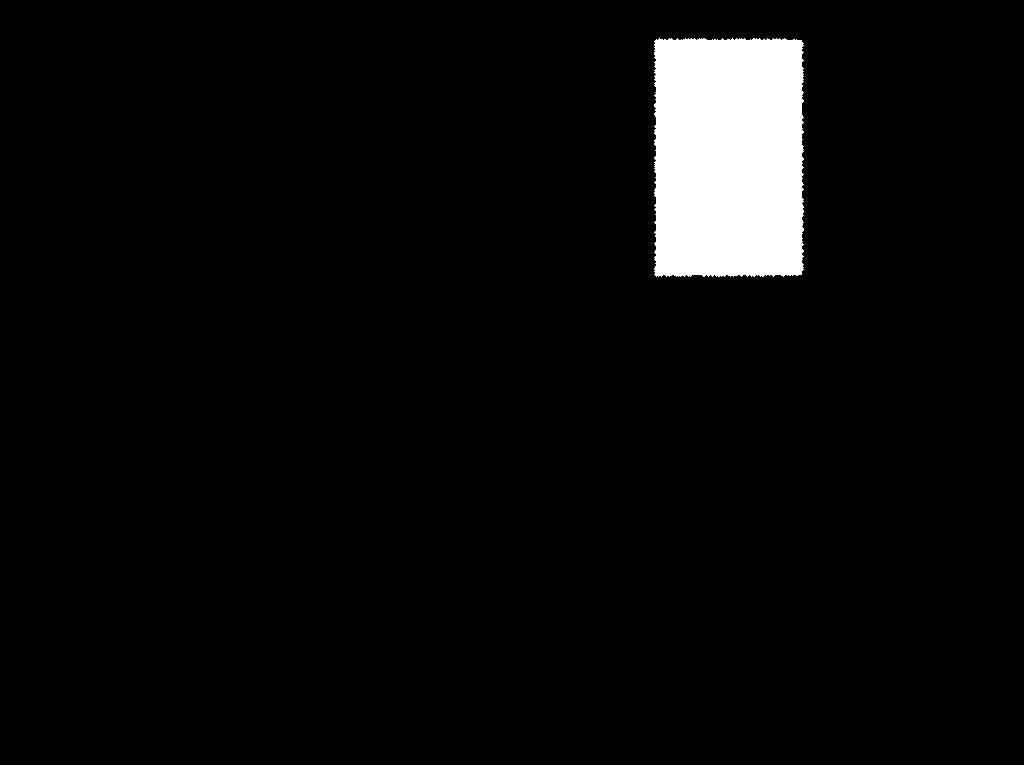

In [ ]:
Image.open('/content/mask.png')